## Counterfactual Fairness in deep generative image models

**Problem Statement**

In this tutorial we implement a Deep Structural Causal Model for Tractable Counterfactual Inference (Pawloski, Castro, et. al.) on the Google Cartoon Dataset of artist-created randomly generated faces. Future work will show how this technique is useful for evaluating counterfactual fairness in deep generative models of faces. 



We study causal reasoning on a per-instance rather than population level, which has valuable applications in, for example, estimating the extent of  fairness of a model, as in "Counterfactual Fairness" (Silva et. al.).​
In "Deep Structural Causal Models for Tractable Counterfactual Inference" (Pawlowski et. al.)  the authors provide:  ​
"a unified framework for structural causal models using modular deep mechanisms"​,
"an efficient approach to estimating counterfactuals by inferring exogenous noise via variational inference or normalising flows"​
We extend these contributions to the case of the Google Cartoon Dataset, a dataset of artist-created and randomly generated cartoon faces.

#### For a detailed explanation of this tutorial, refer to this link : https://www.youtube.com/watch?v=w5v-LX9ZIi0

### Installing the packages ###

In [ ]:
!pip3 install pyro-ppl
!pip3 install natsort
!pip3 install gdown

     |████████████████████████████████| 678 kB 9.3 MB/s 


### Importing dependency libraries

In [ ]:
import pyro
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from pyro.distributions import (
    Bernoulli, Beta, Gamma, Independent, MultivariateNormal,
    Normal, TorchDistribution, LowRankMultivariateNormal
)
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset
import natsort
import PIL
import glob
from sklearn.model_selection import train_test_split
from shutil import copyfile
import os
from pyro.distributions import Normal, TransformedDistribution
import pyro.distributions as dist
from pyro.infer import SVI, TraceGraph_ELBO
from pyro.optim import Adam
from pyro.distributions.transforms import ComposeTransform, SigmoidTransform, AffineTransform
from IPython.display import Image


### Downloading data from Google Drive

**The Google Cartoon Dataset**

The Google Cartoon Dataset is a dataset of artist-created components combined randomly to generate thousands of cartoon faces. From the Google Cartoon Dataset: 
Each image of a cartoon face is composed of 16 components that vary in 10 artwork attributes, 4 color attributes, and 4 proportion attributes. Each of these components and their result in approximately 250 cartoon component artworks and ~1013 possible combinations. Any random selection of attributes produces a visually appealing cartoon without any misaligned artwork; this sometimes involves handling interaction between attributes. For example, the proper way to display a “short beard” changes for different face shapes, which requires the artist to create a “short beard” artwork for each face shape.
The attributes were randomly combined to produce n=10k and n=100k datasets.


#### follow these steps to run the code in google collab
please download dataset from here : https://google.github.io/cartoonset/download.html and put it in your google drive in a folder named **Causal_ML_Project**

In [ ]:
!gdown --id 1ugUzM2XlnpXwwlrgSlYQ9sJjzgBl0iwC

Downloading...
From: https://drive.google.com/uc?id=1ugUzM2XlnpXwwlrgSlYQ9sJjzgBl0iwC
To: /content/cartoonset10k.zip
487MB [00:03, 131MB/s]


In [ ]:
!unzip /content/cartoonset10k.zip

Streaming output truncated to the last 5000 lines.
  inflating: cartoonset10k/cs11471784904293827331.csv  
  inflating: __MACOSX/cartoonset10k/._cs11471784904293827331.csv  
  inflating: cartoonset10k/cs10582658238562413308.csv  
  inflating: __MACOSX/cartoonset10k/._cs10582658238562413308.csv  
  inflating: cartoonset10k/cs10965186012583575108.csv  
  inflating: __MACOSX/cartoonset10k/._cs10965186012583575108.csv  
  inflating: cartoonset10k/cs11322560613105755826.png  
  inflating: __MACOSX/cartoonset10k/._cs11322560613105755826.png  
  inflating: cartoonset10k/cs10445688277628727751.png  
  inflating: __MACOSX/cartoonset10k/._cs10445688277628727751.png  
  inflating: cartoonset10k/cs10474903524141535775.csv  
  inflating: __MACOSX/cartoonset10k/._cs10474903524141535775.csv  
  inflating: cartoonset10k/cs11239694668337705542.png  
  inflating: __MACOSX/cartoonset10k/._cs11239694668337705542.png  
  inflating: cartoonset10k/cs11173001461653885566.csv  
  inflating: __MACOSX/cartoonset

### To run it on your local machine, use this jupyter notebook and mention the path of the dataset

**Loading data and creating folders**

In [ ]:
path = "cartoonset10k/*.csv"
lst = []
for fname in glob.glob(path):
  df = pd.read_csv(f'{fname}', index_col=False, header=None)
  df2 = pd.DataFrame(df[1]).T
  df2.columns = df[0]
  df2.index = [Path(fname).stem]
  lst.append(df2)

merged_df = pd.concat(lst, axis=0, ignore_index=False)

**Split into train-test of the data images and their CSVs**

In [ ]:
train_set, test_set = train_test_split(merged_df,test_size=0.2)

# Create new directories
cwd = Path.cwd()
train_path = cwd/'train_images'
test_path = cwd/'test_images'
train_path.mkdir()
test_path.mkdir()

path = "cartoonset10k/*.png"

train_index = list(train_set.index)
test_index = list(test_set.index)

for fname in glob.glob(path):
  file_name = Path(fname).stem
  if file_name in train_index:
    copyfile(fname, f'{train_path}/{file_name}.png')
  else:
    copyfile(fname, f'{test_path}/{file_name}.png')


**Creating custom dataloader for the images**

In [ ]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = PIL.Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image

In [ ]:
def get_dataloader(batch_size=144, image_size=64, data_dir=f'./train_images', shuffle = False):
  datatransform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.CenterCrop(256),
                                            transforms.Resize(image_size),
                                            transforms.ToTensor(),
                                     ])
    
  data = CustomDataSet(data_dir, transform=datatransform)
  dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
  return dataloader

In [ ]:
cartoon_train_loader = get_dataloader(144, 64, f'./train_images', True)

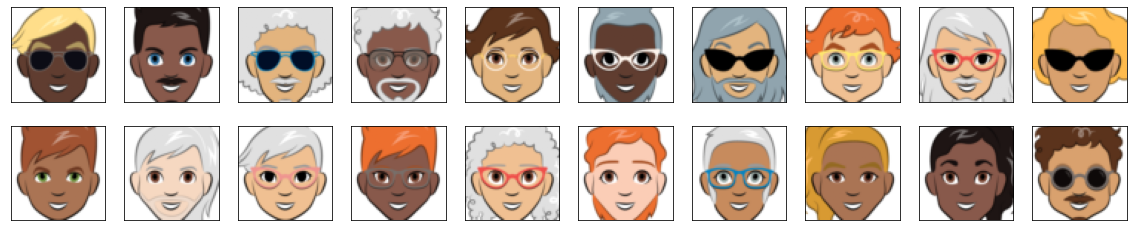

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(cartoon_train_loader)
images = dataiter.next() 

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

**Get data loader for the train and test images of size 64x64**

In [ ]:
# Creating data loaders
train_loader = get_dataloader(144, 64, f'./train_images', True)
test_loader = get_dataloader(144, 64, f'./test_images', True)

### Variational AutoEncoders


Variational Autoencoder is a type of autoencoder in which the latent representation is not reduced to a single point but a distribution. This distribution over latent space helps us to generate some new data points. The relation between the variational inference and the regularization method makes it variational. 

In general, the encoding part in the variational autoencoder gives a latent representation for the mean and the standard deviation and then using that for the normal distribution, we sample the latent space datapoints. We then take the random point from the latent space and then decode it to get a new datapoint in the real image space.

We use Bayes’ Theorem to arrive at a probability distribution for the latent variables  **z**  given the variables of interest  **x**:

#### Classes for creating mean and variance layers for encoder and decooder ####

The basic idea of our implementation is to set up the variational autoencoder by creating an encoder and decoder that both have $\mu$ and logit scale heads as their final two layers. Configuring the heads of the encoder and decoder is accomplished as below:

In [ ]:
class DeepConditional(nn.Module):
    def predict(self, x: torch.Tensor) -> TorchDistribution:
        raise NotImplementedError


class _DeepIndepNormal(DeepConditional):
    def __init__(self, backbone: nn.Module, mean_head: nn.Module, logvar_head: nn.Module):
        super().__init__()
        self.backbone = backbone
        self.mean_head = mean_head
        self.logvar_head = logvar_head

    def forward(self, x):
        h = self.backbone(x)
        mean = self.mean_head(h)
        logvar = self.logvar_head(h)
        return mean, logvar

    def predict(self, x) -> Independent:
        mean, logvar = self(x)
        std = (.5 * logvar).exp()
        event_ndim = len(mean.shape[1:])  # keep only batch dimension
        return Normal(mean, std).to_event(event_ndim)

class DeepIndepNormal(_DeepIndepNormal):
    def __init__(self, backbone: nn.Module, hidden_dim: int, out_dim: int):
        super().__init__(
            backbone=backbone,
            mean_head=nn.Linear(hidden_dim, out_dim),
            logvar_head=nn.Linear(hidden_dim, out_dim)
        )

class Conv2dIndepNormal(_DeepIndepNormal):
    def __init__(self, backbone: nn.Module, hidden_channels: int, out_channels: int = 1):
        super().__init__(
            backbone=backbone,
            mean_head=nn.Conv2d(hidden_channels, out_channels=out_channels, kernel_size=1),
            logvar_head=nn.Conv2d(hidden_channels, out_channels=out_channels, kernel_size=1)
        )

**Creating Encoder and Decoder**

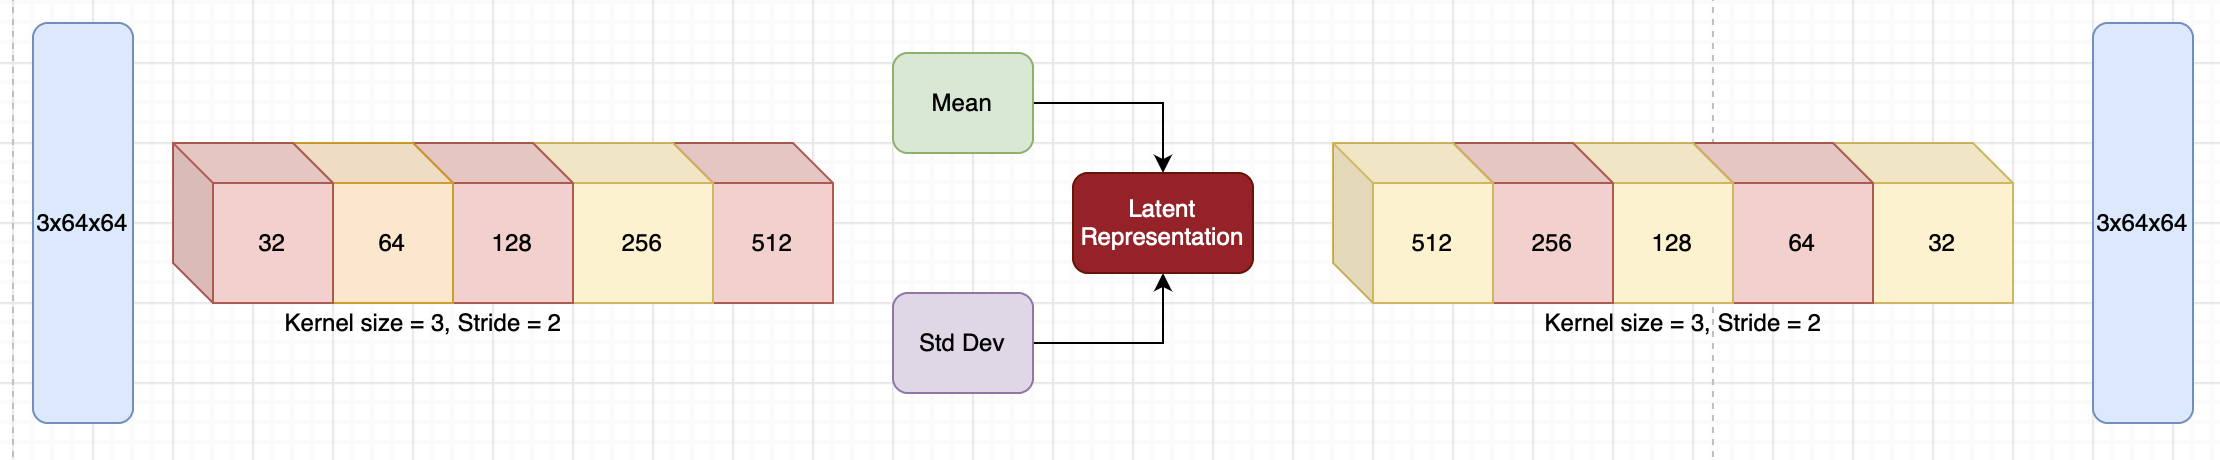

In [ ]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        modules = []
        hidden_dims = [32, 64, 128, 256, 512]
        in_channels = 3
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.linear1 = nn.Linear(hidden_dims[-1]*4, hidden_dim)

    def forward(self, x):
        # define the forward computation on the image x
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        result = self.linear1(result)
        return result

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()

        hidden_dims = [32, 64, 128, 256, 512]
        modules = []

        self.decoder_input1 = nn.Linear(z_dim, hidden_dim)
        self.decoder_input2 = nn.Linear(z_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()
        # Build Decoder
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Sigmoid())

    def forward(self, x):
        # define the forward computation on the latent z
        result = self.decoder_input1(x)
        result = self.decoder_input2(x)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

**Implementing basic VAE architecture**

The variational autoencoder includes an encoder than takes in the variables **x** and  predicts a $\mu$ and logit scale of the latent variational distribution *Q(**z** | **x**)*. The DeepIndepNormal() function takes the “hidden” latent representation returned by the encoder and runs it through additional latent_layers that will be especially useful in the next iteration of the project, where we condition on a set of context variables and infer noise for evaluating a counterfactual. The output of these latent_layers are connected with two fully connected layers which act as the two heads of the resulting neural network, returning a $\mu$ and logit scale of the latent variational distribution *Q(**z** | **x**)*

In [ ]:
# define a PyTorch module for the VAE
class VAE(nn.Module):

    def __init__(self, z_dim=128, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        latent_layers = torch.nn.Sequential(torch.nn.Linear(self.hidden_dim, self.hidden_dim), torch.nn.ReLU())
        self.latent_encoder = DeepIndepNormal(latent_layers, self.hidden_dim, self.z_dim)
        
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.latent_encoder = self.latent_encoder.to('cuda')
        self.use_cuda = use_cuda

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode the latent code z
            loc_img = self.decoder.forward(z)
            
            # score against actual images 
            pyro.sample(
                "obs",
                dist.Bernoulli(loc_img.reshape(-1,64*64*3), validate_args=False).to_event(1),
                obs=x.reshape(-1, 64 * 64 * 3),
            )

            # return the image so we can visualize it later
            return loc_img

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            hidden = self.encoder.forward(x)
            latent_dist = self.latent_encoder.predict(hidden)
            pyro.sample("latent", latent_dist)

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        hidden = self.encoder(x)
        latent_dist = self.latent_encoder.predict(hidden)
        # sample in latent space
        z = latent_dist.sample()
        # decode the image
        loc_img = self.decoder(z)
        return loc_img 


**Main function for training VAE**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def main():
    # clear param store
    pyro.clear_param_store()

    # setup the VAE
    vae = VAE(use_cuda=True)

    # setup the inference algorithm
    elbo = TraceGraph_ELBO()
    optimizer = torch.optim.Adam
    scheduler = pyro.optim.ExponentialLR({'optimizer': optimizer, 'optim_args': {'lr': 0.005}, 'gamma': 0.1})

    svi = SVI(vae.model, vae.guide, scheduler, loss=elbo)

    train_elbo = []
    test_elbo = []
    use_cuda = True
    # training loop
    for epoch in range(100):
        # initialize loss accumulator
        epoch_loss = 0.0

        # run training epoch
        for x in train_loader:
            # if on GPU put mini-batch into CUDA memory
            if use_cuda:
                x = x.cuda()
            # do ELBO gradient and accumulate loss
            epoch_loss += svi.step(x)

        # report training diagnostics
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)
        print(
            "[epoch %03d]  average training loss: %.4f"
            % (epoch, total_epoch_loss_train)
        )

        if epoch % 5 == 0:
            # initialize test loss accumulator
            test_loss = 0.0

            # run test epoch
            for i, x in enumerate(test_loader):
                # if on GPU put mini-batch into CUDA memory
                if use_cuda:
                    x = x.cuda()
                # compute ELBO estimate and accumulate loss
                test_loss += svi.evaluate_loss(x)

            # report test diagnostics
            normalizer_test = len(test_loader.dataset)
            total_epoch_loss_test = test_loss / normalizer_test
            test_elbo.append(total_epoch_loss_test)
            print(
                "[epoch %03d]  average test loss: %.4f" % (epoch, total_epoch_loss_test)
            )

    return vae

**Run the VAE training code and reconstruct image**

[epoch 000]  average training loss: 7000.0117
[epoch 000]  average test loss: 6374.3517


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


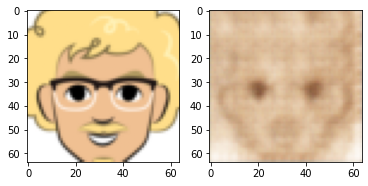

In [ ]:
net = main()
with torch.no_grad():
  for data in random.sample(list(test_loader), 1):
    imgs = data
    imgs = imgs.to(device)
    img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
    plt.subplot(121)
    plt.imshow(np.squeeze(img))
    out = net.reconstruct_img(torch.tensor(imgs).to(device))
    outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
    plt.subplot(122)
    plt.imshow(np.squeeze(outimg))

    break

### Reconstructed Images ###

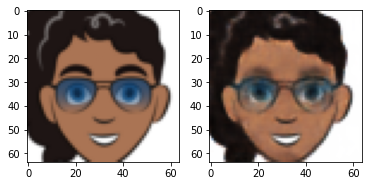

### Normalizing flows using Causal VAEs: An introduction


We’ll walk you through the theory and basic steps to implement the “Deep Structural Causal Models for Tractable Counterfactual Inference” paper by Pawloski, Castro, et. al. Tractable inference on deep counterfactual models enables us to study causal reasoning on a per-instance rather than population level, which has valuable applications, for example, in estimating the extent of fairness of a model. 
 
In "Deep Structural Causal Models for Tractable Counterfactual Inference," Pawlowski, Castro et. al. provide:  ​
"a unified framework for structural causal models using modular deep mechanisms"​
"an efficient approach to estimating counterfactuals by inferring exogenous noise via variational inference or normalising flows"​
 
Here, we use a Causal VAE to implement the underlying machine learning algorithm harnessed by the power of normalizing flows. We model the pixels of an image using this Causal VAE and apply normalizing flows in intermediate steps to reconstruct a given image from the Google Cartoon Dataset. Future work would include extending this approach to other categorical variables in the dataset and performing counterfactual inference. 
 
In the context of this tutorial, we train and test on the n=10k dataset. 


### Using Normalizing Flows with Structural Causal Models 


Normalizing flows enable us to model complex probability distributions by transforming base distributions using the same dimensionality. As we’ll see, this is accomplishable using tractable methods for modeling noise variables ε. Let’s set up the problem: 
 
For the invertible, explicit case: For an observed variable x, a diffeomorphic (gradient preserving) transformation f, and base variable ε ∼ P(ε) such that x = f(ε), the output density p(x) can be computed as p(x) = p(ε)|det∇f(ε)|−1, evaluated at ε = f−1(x). We have here our standard change of variable formula applied to the markov kernels of Pearl structural causal models.
***
**Equation 1:**


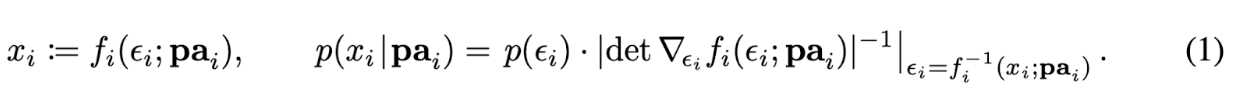


For the amortised, explicit case: Since all intermediate transformations in the above formulation of the problem occur in the original (high dimensional) space, we find ourselves looking for more tractable methods. As suggested by Palowski, Castro, et. al., we can use arbitrary functional forms for the structural assignments in the causal model, which will loses us the ability to perform inversions and tractable likelihoods for modeling (x_{
k} |**pa_{k]**). To tackle this, the authors suggest separating the assignments *f_k* into a ‘low-level’ invertible component *h_{k}*,and a ‘high level’ non-invertible component  *g_{k}*, where $\epsilon_{k}$  is decomposed into two units, ε =(u_{k},z_{k}) such that:  
***
**Equation 2:**

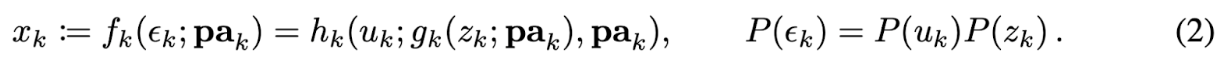

One implementation choice for these methods is that of a convolutional neural network to model *g_{k}* and location and scale transformation performed by *h_{k}*.
However, we come up against the same intractability problem as the conditional likelihood  because $z_{k}$ cannot be marginalized out to calculate P(x_{k} | **pa_[k}**$. 
 
We can then introduce a variational distribution *Q(z_{k} | x_{k}, **pa_{k}**)* which we can use as a lower bound on the true marginal conditional log-likelihood, that instead we will be maximizing. We will be using a variational autoencoder to realize this task. 
***
**Equation 3**

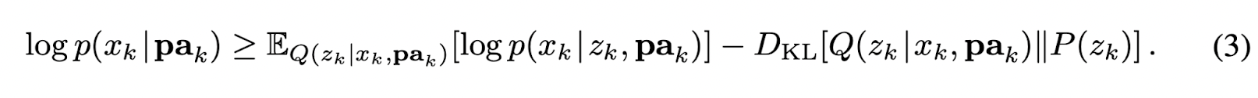

We calculate the argument of the expectation above analogously to Equation (1).
***
**Equation 4**

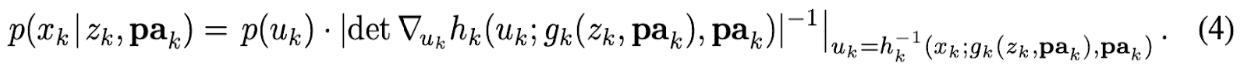

In our implementation, we use a variational autoencoder where the encoder function e_{k}(d_{x}; **pa_{k}** that  outputs the parameters of a simple distribution over $z_{k}$

**Adding Normalizing Flow**

In [25]:
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()
        modules = []
        hidden_dims = [32, 64, 128, 256, 512]
        in_channels = 3
        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.linear1 = nn.Linear(hidden_dims[-1]*4, hidden_dim)

    def forward(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        result = self.linear1(result)
        return result

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super().__init__()

        hidden_dims = [32, 64, 128, 256, 512]
        modules = []

        self.decoder_input1 = nn.Linear(z_dim, hidden_dim)
        self.decoder_input2 = nn.Linear(z_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()
        # Build Decoder
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            #nn.Sigmoid()
        )

    def forward(self, x):
        result = self.decoder_input1(x)
        result = self.decoder_input2(x)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

**Define a PyTorch module for the VAE**


The convolutional neural network decoder receives the latent distribution Q(**z** | **x**), represented by a  $\mu_{z}$ and logit scale, and predicts the P(**x** | **z**). Finally an AffineTransform is applied to the predicted distribution (of type TransformedDistribution), which can be represented as the following element-wise transformation:   
x = $\mu_{\hat x} + \sigma_{\hat x} \odot$ **x**


In [26]:
class VAE(nn.Module):

    def __init__(self, z_dim=128, hidden_dim=400, use_cuda=False):
        super().__init__()
        # create the encoder and decoder networks
        
        self.img_shape = (3, 64, 64)
        self.logstd_init = -5
        self.register_buffers()  
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.decoder = Conv2dIndepNormal(self.decoder,3, 3)
        torch.nn.init.zeros_(self.decoder.logvar_head.weight)
        self.decoder.logvar_head.weight.requires_grad = False
        torch.nn.init.constant_(self.decoder.logvar_head.bias, self.logstd_init)
        self.decoder.logvar_head.bias.requires_grad = False
        
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim
        latent_layers = torch.nn.Sequential(torch.nn.Linear(self.hidden_dim, self.hidden_dim), torch.nn.ReLU())
        self.latent_encoder = DeepIndepNormal(latent_layers, self.hidden_dim, self.z_dim)
        
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.latent_encoder = self.latent_encoder.to(device)
        self.use_cuda = use_cuda
        
    def register_buffers(self):
        self.register_buffer('x_base_loc', torch.zeros([3, 64, 64], requires_grad=False))
        self.register_buffer('x_base_scale', torch.ones([3, 64, 64], requires_grad=False))
    
    def _get_transformed_x_dist(self, latent):
        x_pred_dist = self.decoder.predict(latent)
        x_base_dist = Normal(self.x_base_loc, self.x_base_scale).to_event(3)

        # preprocess data
        preprocess_transform = self._get_preprocess_transforms()

        if isinstance(x_pred_dist, Independent):
            x_pred_dist = x_pred_dist.base_dist
            x_reparam_transform = AffineTransform(x_pred_dist.loc, x_pred_dist.scale, 3)
        
        return TransformedDistribution(x_base_dist, ComposeTransform([x_reparam_transform]))

    def _get_preprocess_transforms(self):
        alpha = 0.05
        num_bits = 8

        # Map to [0,1]
        a1 = AffineTransform(0.,(1. / 2 ** num_bits))

        # Map into unconstrained space as done in RealNVP
        a2 = AffineTransform(alpha, (1 - alpha))

        s = SigmoidTransform()
        preprocess_transform = ComposeTransform([a1, a2, s.inv])
                                                    
        return preprocess_transform.inv

    # define the model p(x|z)p(z)
    def model(self, x):

        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.shape[0]):
            
            # setup hyperparameters for prior p(z)
            z_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z_scale = torch.ones(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))
            
            # decode the latent code z
            loc_img = self._get_transformed_x_dist(z)

            # Sample values from the returned distribution
            yy = pyro.sample('yy', loc_img)
            
            # score against actual images
            pyro.sample(
                "obs",
                dist.Bernoulli(yy.view(-1,64*64*3), validate_args=False).to_event(1),
                obs=x.reshape(-1, 64 * 64 * 3),
            )

            return yy, z

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.shape[0]):
            # use the encoder to get the parameters used to define q(z|x)
            hidden = self.encoder.forward(x)
            latent_dist = self.latent_encoder.predict(hidden)
            pyro.sample("latent", latent_dist)
            

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        hidden = self.encoder(x)
        latent_dist = self.latent_encoder.predict(hidden)
        # sample in latent space
        z = latent_dist.sample()
        # decode the image 
        loc_img = self.decoder.predict(z)
        # sample in reconstruction space
        loc_img = loc_img.sample()
        return loc_img 


**Call the normalizing flow and plot reconstruction images**

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:441: UserWarning: logvar_head.weight was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  f"{param_name} was not registered in the param store "
/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:441: UserWarning: logvar_head.bias was not registered in the param store because requires_grad=False. You can silence this warning by calling my_module.train(False)
  f"{param_name} was not registered in the param store "
/usr/local/lib/python3.7/dist-packages/pyro/util.py:295: UserWarning: Found vars in model but not guide: {'yy'}
  model_vars - guide_vars - enum_vars


[epoch 000]  average training loss: 326889697565826240.0000
[epoch 000]  average test loss: 264081.5194


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


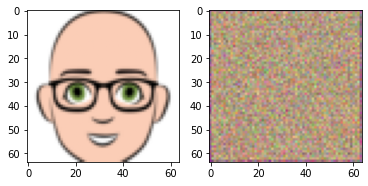

In [27]:
net = main()
with torch.no_grad():
  for data in random.sample(list(test_loader), 1):
    imgs = data
    imgs = imgs.to(device)
    img = np.transpose(imgs[0].cpu().numpy(), [1,2,0])
    plt.subplot(121)
    plt.imshow(np.squeeze(img))
    out = net.reconstruct_img(torch.tensor(imgs).to(device))
    outimg = np.transpose(out[0].cpu().numpy(), [1,2,0])
    plt.subplot(122)
    plt.imshow(np.squeeze(outimg))
    break

### Reconstructed Images ###

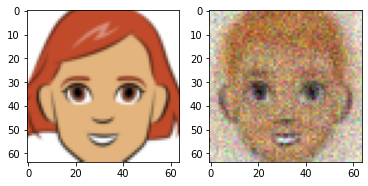

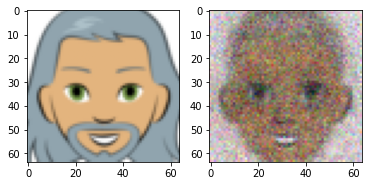

### Conclusion
We were able to implement a Causal VAE with the normalizing flows structure on a 10k set of faces from the Cartoon Dataset. We had lukewarm results in that the faces could be reconstructed only at a blurry level with some key features being altered. Because the Causal VAE on its own, without using normalizing flows, produced good results, we suspect that improvements could be made on the normalizing flows structure, such as perhaps in using batch normalization via affine transforms and using affine transforms to otherwise preprocess the data, as in the paper. Furthermore, it would be worth exploring other options such as the RealNVP model that the paper also does reference.  

Future iterations on this project also include incorporating other endogenous variables into the SCM. Additionally, another important improvement would be implementing counterfactual inference to create images from existing images that represent counterfactual queries, such as “What would this face look like had they been wearing blue glasses?”

Using deep counterfactual inference in SCMs ​has a lot of interesting and valuable applications in transparency, fairness, and robustness in deep learning as well as in developing decision-support systems and personalized medicine. We hope you enjoyed this tutorial and keep on keepin’ on in your Causality in ML journey!  
